In [1]:
# import stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

# read in the data, parse the dates, and set the index
df = pd.read_csv('../../data/shear_velocity/shear_velocity_2023.csv', parse_dates=['Date_Time'], index_col='Date_Time')
# separate by season
spring = df['2023-03-01':'2023-06-21'].copy()
summer = df['2023-06-22':'2023-09-21'].copy()

### Calculate u*/ws for different grain sizes

#### Spring

In [2]:
# spring u*/ws values (settling velocities) - from the settling velocity csv data
spring.loc[:, '0.5'] = df['u*'] / 0.00000007
spring.loc[:, '1'] = df['u*'] / 0.00000029
spring.loc[:, '2'] = df['u*'] / 0.00000125
spring.loc[:, '5'] = df['u*'] / 0.00001235
spring.loc[:, '20'] = df['u*'] / 0.00023806
spring.loc[:, '45'] = df['u*'] / 0.0013
spring.loc[:, '63'] = df['u*'] / 0.0024
spring.loc[:, '100'] = df['u*'] / 0.0060
spring.loc[:, '200'] = df['u*'] / 0.01761
spring.loc[:, '280'] = df['u*'] / 0.02870
spring.loc[:, '500'] = df['u*'] / 0.06183
spring.loc[:, '700'] = df['u*'] / 0.09129
spring.loc[:, '850'] = df['u*'] / 0.11186
spring.loc[:, '1000'] = df['u*'] / 0.13080
spring.loc[:, '2000'] = df['u*'] / 0.21894

Plot

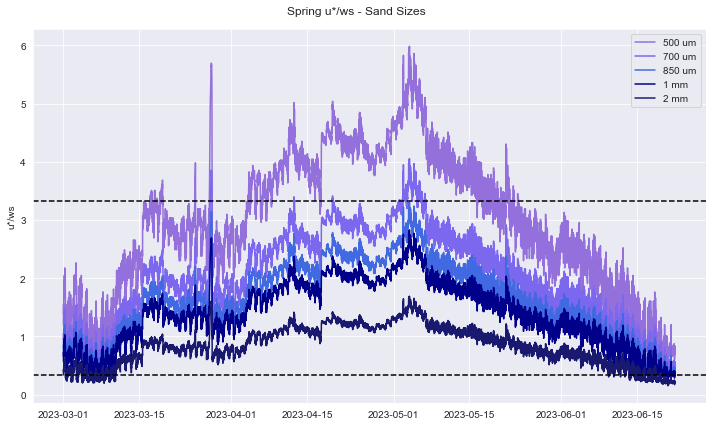

In [3]:
# plot for sping u*/ws values (settling velocities) for all sizes
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))

#plt.plot(spring['200'], color='orchid', label='200 um')
plt.plot(spring['500'], color='mediumpurple', label='500 um')
plt.plot(spring['700'], color='mediumslateblue', label='700 um')
plt.plot(spring['850'], color='royalblue', label='850 um')
plt.plot(spring['1000'], color='darkblue', label='1 mm')
plt.plot(spring['2000'], color='midnightblue', label='2 mm')

plt.axhline(y=0.333, color='k', linestyle='--')
plt.axhline(y=3.333, color='k', linestyle='--')

plt.ylabel('u*/ws')
plt.xlabel('')
plt.legend()
plt.suptitle('Spring u*/ws - Sand Sizes')
plt.tight_layout()
plt.show()

Calculate total time in suspension

In [4]:
# calculate the total time where u*/ws > 3.333 for each grain size in spring
upper = 3.33
grain_sizes = [col for col in spring.columns if col not in ['u*']]  # excludes the u* column

# calculate the time delta between rows (in hours)
timestep_hours = (spring.index[1] - spring.index[0]).total_seconds() / 3600 # convert to hours, 15 min intervals are 0.25 hours
mixed_counts = (spring[grain_sizes] > upper).sum() # count the number of time steps in range
mixed_hours = mixed_counts * timestep_hours # convert counts to hours

# save as DataFrame
suspended_spring_times = pd.DataFrame({
    'size': [float(size) for size in grain_sizes],  # convert to float if needed
    'time': mixed_hours.values
})

Calculate total time as mixed load 

In [5]:
# calculate the total time in hours where 0.33 < u*/ws < 3.33 for each grain size in spring
lower = 0.33
upper = 3.33
grain_sizes = [col for col in spring.columns if col not in ['u*']]  # excludes the u* column

# calculate the time delta between rows (in hours)
timestep_hours = (spring.index[1] - spring.index[0]).total_seconds() / 3600 # convert to hours, 15 min intervals are 0.25 hours
mixed_counts = ((spring[grain_sizes] > lower) & (spring[grain_sizes] < upper)).sum() # count the number of time steps in range
mixed_hours = mixed_counts * timestep_hours # convert counts to hours

# save as DataFrame
mixed_spring_times = pd.DataFrame({
    'size': [float(size) for size in grain_sizes],  # convert to float if needed
    'time': mixed_hours.values
})

#### Summer

In [6]:
# summer u*/ws values (settling velocities)
summer.loc[:, '0.5'] = df['u*'] / 0.00000008
summer.loc[:, '1'] = df['u*'] / 0.00000034
summer.loc[:, '2'] = df['u*'] / 0.00000151
summer.loc[:, '5'] = df['u*'] / 0.00001487
summer.loc[:, '20'] = df['u*'] / 0.00028262
summer.loc[:, '45'] = df['u*'] / 0.0015
summer.loc[:, '63'] = df['u*'] / 0.0028
summer.loc[:, '100'] = df['u*'] / 0.0069
summer.loc[:, '200'] = df['u*'] / 0.01989
summer.loc[:, '280'] = df['u*'] / 0.03215
summer.loc[:, '500'] = df['u*'] / 0.06815
summer.loc[:, '700'] = df['u*'] / 0.09952
summer.loc[:, '850'] = df['u*'] / 0.12107
summer.loc[:, '1000'] = df['u*'] / 0.14065
summer.loc[:, '2000'] = df['u*'] / 0.22928

Plot

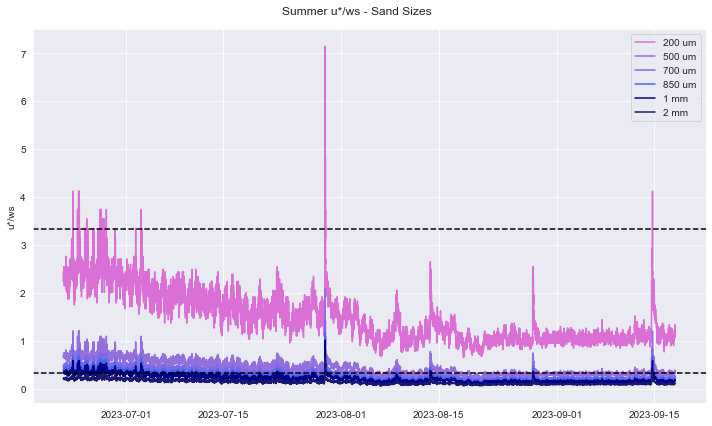

In [7]:
# plot for sping u*/ws values (settling velocities) for all sizes
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))

#plt.plot(summer['100'], color='lightpink', label='100 um')
plt.plot(summer['200'], color='orchid', label='200 um')
plt.plot(summer['500'], color='mediumpurple', label='500 um')
plt.plot(summer['700'], color='mediumslateblue', label='700 um')
plt.plot(summer['850'], color='royalblue', label='850 um')
plt.plot(summer['1000'], color='darkblue', label='1 mm')
plt.plot(summer['2000'], color='midnightblue', label='2 mm')

plt.axhline(y=0.333, color='k', linestyle='--')
plt.axhline(y=3.333, color='k', linestyle='--')

plt.ylabel('u*/ws')
plt.xlabel('')
plt.legend()
plt.suptitle('Summer u*/ws - Sand Sizes')
plt.tight_layout()
plt.show()

Calculate total time in suspension

In [8]:
# calculate the total time where u*/ws > 3.333 for each grain size in spring
upper = 3.33
grain_sizes = [col for col in summer.columns if col not in ['u*']]  # excludes the u* column
timestep_hours = (summer.index[1] - summer.index[0]).total_seconds() / 3600 # calculate the time delta between rows (in hours)

# dictionary to hold timestamps for each grain size
summer_suspension_periods = {}

mixed_counts = (summer[grain_sizes] > upper).sum() # count the number of time steps in range
mixed_hours = mixed_counts * timestep_hours # convert counts to hours

# loop over grain sizes to collect timestamps where condition is met
for size in grain_sizes:
    # Get timestamps where condition is met
    times_met = summer.index[summer[size] > upper]
    summer_suspension_periods[float(size)] = times_met  # store as float key if you prefer

# save as DataFrame
suspended_summer_times = pd.DataFrame({
    'size': [float(size) for size in grain_sizes],  # convert to float if needed
    'time': mixed_hours.values
})

Calculate total time as mixed load

In [9]:
# calculate the total time in hours where 0.33 < u*/ws < 3.33 for each grain size in spring
lower = 0.33
upper = 3.33
grain_sizes = [col for col in summer.columns if col not in ['u*']]  # excludes the u* column

# calculate the time delta between rows (in hours)
timestep_hours = (summer.index[1] - summer.index[0]).total_seconds() / 3600 # convert to hours, 15 min intervals are 0.25 hours
mixed_counts = ((summer[grain_sizes] > lower) & (summer[grain_sizes] < upper)).sum() # count the number of time steps in range
mixed_hours = mixed_counts * timestep_hours # convert counts to hours

# save as DataFrame
mixed_summer_times = pd.DataFrame({
    'size': [float(size) for size in grain_sizes],  # convert to float if needed
    'time': mixed_hours.values
})

### Transport mode plots

In [10]:
# classify the data by grain size class
def classify_grain(size):
    if size >= 850:
        return 'Coarse Sand'
    elif size >= 63:
        return 'Fine Sand'
    elif size >= 2:
        return 'Silt'
    else:
        return 'Clay'

suspended_spring_times['class'] = suspended_spring_times['size'].apply(classify_grain)
suspended_summer_times['class'] = suspended_summer_times['size'].apply(classify_grain)
mixed_spring_times['class'] = mixed_spring_times['size'].apply(classify_grain)
mixed_summer_times['class'] = mixed_summer_times['size'].apply(classify_grain)

Spring

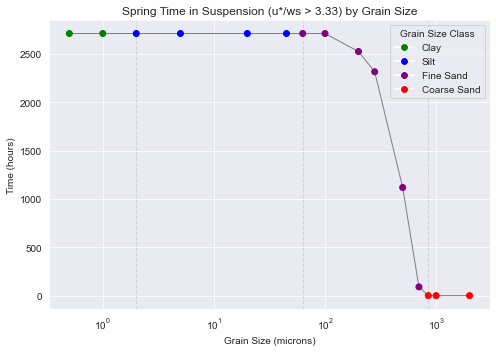

In [11]:
# SUSPENSION PLOT
# color mapping for classes
class_colors = {
    'Clay': 'green',
    'Silt': 'blue',
    'Fine Sand': 'purple',
    'Coarse Sand': 'red'
}
# map colors to each point
colors = suspended_spring_times['class'].map(class_colors)

plt.figure(figsize=(7, 5))

# add vertical dashed lines for class boundaries
for boundary in [2, 63, 850]:
    plt.axvline(x=boundary, color='lightgray', linestyle='--', linewidth=1, zorder=1)

# plot connecting line
# sort data by size for line connection
sorted_df = suspended_spring_times.sort_values('size')
plt.plot(
    sorted_df['size'],
    sorted_df['time'],
    color='gray',
    linestyle='-',
    linewidth=1,
    zorder=1
)

# scatter plot for suspended spring times
plt.scatter(
    suspended_spring_times['size'],
    suspended_spring_times['time'],
    c=colors,
    label=None
)

plt.xlabel('Grain Size (microns)')
plt.ylabel('Time (hours)')
plt.title('Spring Time in Suspension (u*/ws > 3.33) by Grain Size')
plt.xscale('log')
plt.tight_layout()

# custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Clay', markerfacecolor='green', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Silt', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Fine Sand', markerfacecolor='purple', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Coarse Sand', markerfacecolor='red', markersize=8)
]
plt.legend(handles=legend_elements, title='Grain Size Class')

plt.show()

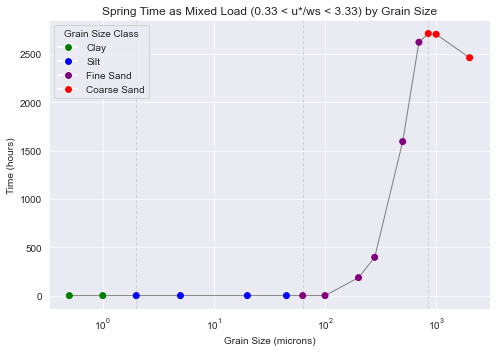

In [12]:
# MIXED LOAD PLOT
# color mapping for classes
class_colors = {
    'Clay': 'green',
    'Silt': 'blue',
    'Fine Sand': 'purple',
    'Coarse Sand': 'red'
}
# map colors to each point
colors = mixed_spring_times['class'].map(class_colors)

plt.figure(figsize=(7, 5))

# add vertical dashed lines for class boundaries
for boundary in [2, 63, 850]:
    plt.axvline(x=boundary, color='lightgray', linestyle='--', linewidth=1, zorder=1)

# plot connecting line
# sort data by size for line connection
sorted_df = mixed_spring_times.sort_values('size')
plt.plot(
    sorted_df['size'],
    sorted_df['time'],
    color='gray',
    linestyle='-',
    linewidth=1,
    zorder=1
)

# scatter plot for suspended spring times
plt.scatter(
    mixed_spring_times['size'],
    mixed_spring_times['time'],
    c=colors,
    label=None
)

plt.xlabel('Grain Size (microns)')
plt.ylabel('Time (hours)')
plt.title('Spring Time as Mixed Load (0.33 < u*/ws < 3.33) by Grain Size')
plt.xscale('log')
plt.tight_layout()

# custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Clay', markerfacecolor='green', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Silt', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Fine Sand', markerfacecolor='purple', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Coarse Sand', markerfacecolor='red', markersize=8)
]
plt.legend(handles=legend_elements, title='Grain Size Class')

plt.show()

Summer

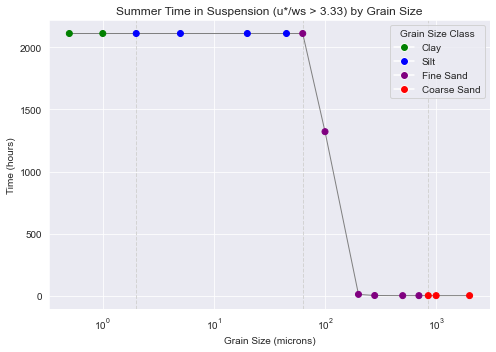

In [13]:
# SUSPENSION PLOT
# color mapping for classes
class_colors = {
    'Clay': 'green',
    'Silt': 'blue',
    'Fine Sand': 'purple',
    'Coarse Sand': 'red'
}
# map colors to each point
colors = suspended_summer_times['class'].map(class_colors)

plt.figure(figsize=(7, 5))

# add vertical dashed lines for class boundaries
for boundary in [2, 63, 850]:
    plt.axvline(x=boundary, color='lightgray', linestyle='--', linewidth=1, zorder=1)

# plot connecting line
# sort data by size for line connection
sorted_df = suspended_summer_times.sort_values('size')
plt.plot(
    sorted_df['size'],
    sorted_df['time'],
    color='gray',
    linestyle='-',
    linewidth=1,
    zorder=1
)

# scatter plot for suspended spring times
plt.scatter(
    suspended_summer_times['size'],
    suspended_summer_times['time'],
    c=colors,
    label=None
)

plt.xlabel('Grain Size (microns)')
plt.ylabel('Time (hours)')
plt.title('Summer Time in Suspension (u*/ws > 3.33) by Grain Size')
plt.xscale('log')
plt.tight_layout()

# custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Clay', markerfacecolor='green', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Silt', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Fine Sand', markerfacecolor='purple', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Coarse Sand', markerfacecolor='red', markersize=8)
]
plt.legend(handles=legend_elements, title='Grain Size Class')

plt.show()

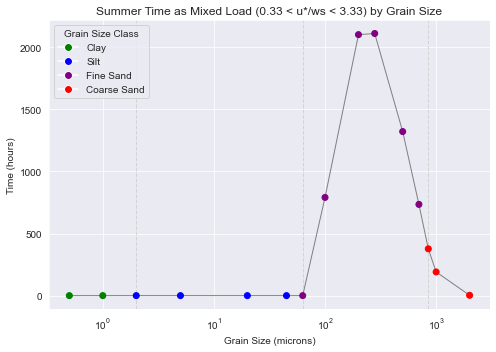

In [14]:
# MIXED LOAD PLOT
# color mapping for classes
class_colors = {
    'Clay': 'green',
    'Silt': 'blue',
    'Fine Sand': 'purple',
    'Coarse Sand': 'red'
}
# map colors to each point
colors = mixed_summer_times['class'].map(class_colors)

plt.figure(figsize=(7, 5))

# add vertical dashed lines for class boundaries
for boundary in [2, 63, 850]:
    plt.axvline(x=boundary, color='lightgray', linestyle='--', linewidth=1, zorder=1)

# plot connecting line
# sort data by size for line connection
sorted_df = mixed_summer_times.sort_values('size')
plt.plot(
    sorted_df['size'],
    sorted_df['time'],
    color='gray',
    linestyle='-',
    linewidth=1,
    zorder=1
)

# scatter plot for suspended spring times
plt.scatter(
    mixed_summer_times['size'],
    mixed_summer_times['time'],
    c=colors,
    label=None
)

plt.xlabel('Grain Size (microns)')
plt.ylabel('Time (hours)')
plt.title('Summer Time as Mixed Load (0.33 < u*/ws < 3.33) by Grain Size')
plt.xscale('log')
plt.tight_layout()

# custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Clay', markerfacecolor='green', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Silt', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Fine Sand', markerfacecolor='purple', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Coarse Sand', markerfacecolor='red', markersize=8)
]
plt.legend(handles=legend_elements, title='Grain Size Class')

plt.show()

Both Seasons Combined

In [15]:
# function to plot each season/class combination
def plot_season(df, season_label, color, markers):
    for grain_class, marker in markers.items():
        class_df = df[df['class'] == grain_class]
        # sort by size for line connection
        class_df = class_df.sort_values('size')
        # connect points for each class
        plt.plot(
            class_df['size'],
            class_df['time'],
            color=color,
            linestyle='-',
            linewidth=1,
            alpha=0.5,
            zorder=2
        )
        # scatter points
        plt.scatter(
            class_df['size'],
            class_df['time'],
            color=color,
            marker=marker,
            edgecolor='black',
            label=f"{season_label} - {grain_class}",
            s=60,
            zorder=3
        )

# function to plot each subplot
def subplot_season(ax, df, season_label, color, markers):
    for grain_class, marker in markers.items():
        class_df = df[df['class'] == grain_class].sort_values('size')
        # Connect points for each class
        ax.plot(
            class_df['size'],
            class_df['time'],
            color=color,
            linestyle='-',
            linewidth=1,
            alpha=0.5,
            zorder=2
        )
        # Scatter points with black edge
        ax.scatter(
            class_df['size'],
            class_df['time'],
            color=color,
            marker=marker,
            s=60,
            edgecolor='black',
            linewidth=1,
            zorder=3
        )

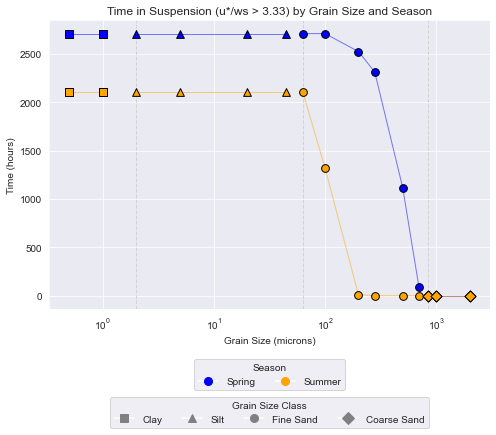

In [16]:
# SUSPENSION PLOT
# color and marker mapping
season_colors = {'Spring': 'blue', 'Summer': 'orange'}
markers = { 'Clay': 's', 'Silt': '^', 'Fine Sand': 'o', 'Coarse Sand': 'D'}

plt.figure(figsize=(7, 5))

# add vertical dashed lines for class boundaries
for boundary in [2, 63, 850]:
    plt.axvline(x=boundary, color='lightgray', linestyle='--', linewidth=1, zorder=1)

# plot spring data
plot_season(suspended_spring_times, 'Spring', season_colors['Spring'], markers)
# plot summer data
plot_season(suspended_summer_times, 'Summer', season_colors['Summer'], markers)

plt.xlabel('Grain Size (microns)')
plt.ylabel('Time (hours)')
plt.title('Time in Suspension (u*/ws > 3.33) by Grain Size and Season')
plt.xscale('log')
plt.tight_layout()

# legend for season
season_legend = [
    Line2D([0], [0], marker='o', color='w', label=season,
            markerfacecolor=color, markeredgecolor=color, markersize=8)
    for season, color in season_colors.items()]
# legend for grain size classes (shapes)
class_legend = [
    Line2D([0], [0], marker=marker, color='w', label=grain_class,
            markerfacecolor='gray', markeredgecolor='gray', markersize=8,)
    for grain_class, marker in markers.items()]
# place legends at the bottom
first_legend = plt.legend(handles=season_legend, title='Season', loc='lower center', bbox_to_anchor=(0.5, -0.30), ncol=len(season_legend))
second_legend = plt.legend(handles=class_legend, title='Grain Size Class', loc='lower center', bbox_to_anchor=(0.5, -0.43), ncol=len(class_legend))
plt.gca().add_artist(first_legend)

plt.show()

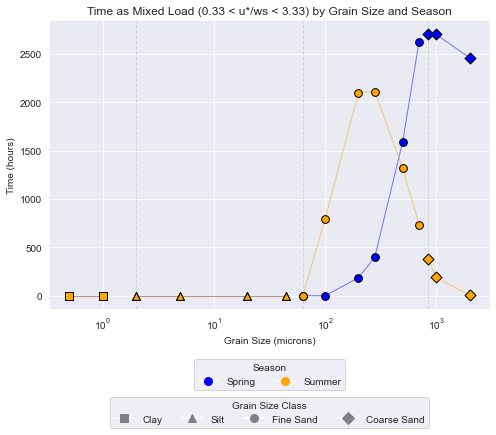

In [17]:
# MIXED LOAD PLOT
# color and marker mapping
season_colors = {'Spring': 'blue', 'Summer': 'orange'}
markers = { 'Clay': 's', 'Silt': '^', 'Fine Sand': 'o', 'Coarse Sand': 'D'}

plt.figure(figsize=(7, 5))

# add vertical dashed lines for class boundaries
for boundary in [2, 63, 850]:
    plt.axvline(x=boundary, color='lightgray', linestyle='--', linewidth=1, zorder=1)

# plot spring data
plot_season(mixed_spring_times, 'Spring', season_colors['Spring'], markers)
# plot summer data
plot_season(mixed_summer_times, 'Summer', season_colors['Summer'], markers)

plt.xlabel('Grain Size (microns)')
plt.ylabel('Time (hours)')
plt.title('Time as Mixed Load (0.33 < u*/ws < 3.33) by Grain Size and Season')
plt.xscale('log')
plt.tight_layout()

# legend for season
season_legend = [
    Line2D([0], [0], marker='o', color='w', label=season,
            markerfacecolor=color, markeredgecolor=color, markersize=8)
    for season, color in season_colors.items()]
# legend for grain size classes (shapes)
class_legend = [
    Line2D([0], [0], marker=marker, color='w', label=grain_class,
            markerfacecolor='gray', markeredgecolor='gray', markersize=8,)
    for grain_class, marker in markers.items()]
# place legends at the bottom
first_legend = plt.legend(handles=season_legend, title='Season', loc='lower center', bbox_to_anchor=(0.5, -0.30), ncol=len(season_legend))
second_legend = plt.legend(handles=class_legend, title='Grain Size Class', loc='lower center', bbox_to_anchor=(0.5, -0.43), ncol=len(class_legend))
plt.gca().add_artist(first_legend)

plt.show()

Subplot

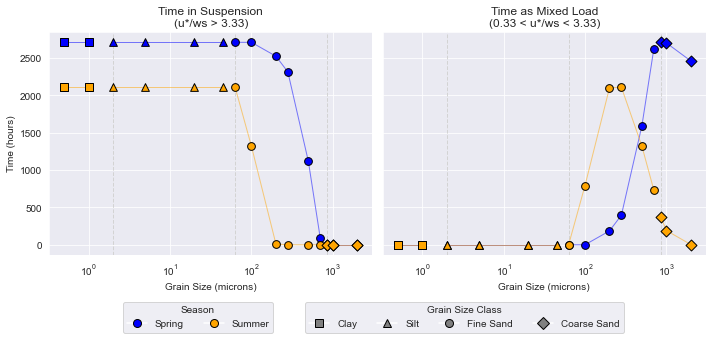

In [18]:
# color and marker mapping
season_colors = {'Spring': 'blue', 'Summer': 'orange'}
markers = {'Clay': 's', 'Silt': '^', 'Fine Sand': 'o', 'Coarse Sand': 'D'}

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# suspension load plot (left) 
ax = axes[0]
for boundary in [2, 63, 850]:
    ax.axvline(x=boundary, color='lightgray', linestyle='--', linewidth=1, zorder=1)
subplot_season(ax, suspended_spring_times, 'Spring', season_colors['Spring'], markers)
subplot_season(ax, suspended_summer_times, 'Summer', season_colors['Summer'], markers)
ax.set_xlabel('Grain Size (microns)')
ax.set_ylabel('Time (hours)')
ax.set_title('Time in Suspension\n(u*/ws > 3.33)')
ax.set_xscale('log')

# mixed plot (right)
ax = axes[1]
for boundary in [2, 63, 850]:
    ax.axvline(x=boundary, color='lightgray', linestyle='--', linewidth=1, zorder=1)
subplot_season(ax, mixed_spring_times, 'Spring', season_colors['Spring'], markers)
subplot_season(ax, mixed_summer_times, 'Summer', season_colors['Summer'], markers)
ax.set_xlabel('Grain Size (microns)')
ax.set_title('Time as Mixed Load\n(0.33 < u*/ws < 3.33)')
ax.set_xscale('log')

plt.tight_layout(rect=[0, 0.15, 1, 1])  # leave space at the bottom for legends

# Legends at the bottom
# season legend (color dots with black edge)
season_legend = [
    Line2D([0], [0], marker='o', color='w', label=season,
            markerfacecolor=color, markeredgecolor='black', markersize=8)
    for season, color in season_colors.items()
]
# Grain size class legend (gray shapes with black edge)
class_legend = [
    Line2D([0], [0], marker=marker, color='w', label=grain_class,
            markerfacecolor='gray', markeredgecolor='black', markersize=8)
    for grain_class, marker in markers.items()
]

# Add legends below both plots
fig.legend(handles=season_legend, title='Season', loc='lower center', bbox_to_anchor=(0.28, 0.05), ncol=len(season_legend))
fig.legend(handles=class_legend, title='Grain Size Class', loc='lower center', bbox_to_anchor=(0.65, 0.05), ncol=len(class_legend))

plt.show()

Subplot + Bedload

In [20]:
# importing bedload data
bedload_spring_times = pd.read_csv('../../data/bedload_tauc/bedload_times/bedload_spring_times.csv')
bedload_summer_times = pd.read_csv('../../data/bedload_tauc/bedload_times/bedload_summer_times.csv')

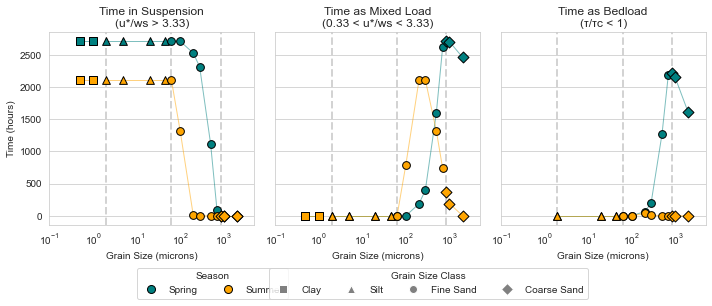

In [22]:
# color and marker mapping
season_colors = {'Spring': 'teal', 'Summer': 'orange'}
markers = {'Clay': 's', 'Silt': '^', 'Fine Sand': 'o', 'Coarse Sand': 'D'}
sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(10, 4.5), sharey=True)

# set the same x-axis limits for all subplots
x_min = 0.1   # or min grain size in your data
x_max = 5000  # or max grain size in your data
for ax in axes:
    ax.set_xlim(x_min, x_max)

# suspension load plot (left) 
ax = axes[0]
for boundary in [2, 63, 850]:
    ax.axvline(x=boundary, color='lightgray', linestyle='--', linewidth=2, zorder=1)
subplot_season(ax, suspended_spring_times, 'Spring', season_colors['Spring'], markers)
subplot_season(ax, suspended_summer_times, 'Summer', season_colors['Summer'], markers)
ax.set_xlabel('Grain Size (microns)')
ax.set_ylabel('Time (hours)')
ax.set_title('Time in Suspension\n(u*/ws > 3.33)')
ax.set_xscale('log')
ax.xaxis.grid(False)

# mixed plot (middle)
ax = axes[1]
for boundary in [2, 63, 850]:
    ax.axvline(x=boundary, color='lightgray', linestyle='--', linewidth=2, zorder=1)
subplot_season(ax, mixed_spring_times, 'Spring', season_colors['Spring'], markers)
subplot_season(ax, mixed_summer_times, 'Summer', season_colors['Summer'], markers)
ax.set_xlabel('Grain Size (microns)')
ax.set_title('Time as Mixed Load\n(0.33 < u*/ws < 3.33)')
ax.set_xscale('log')
ax.xaxis.grid(False)

# bedload plot (right)
ax = axes[2]
for boundary in [2, 63, 850]:
    ax.axvline(x=boundary, color='lightgray', linestyle='--', linewidth=2, zorder=1)
subplot_season(ax, bedload_spring_times, 'Spring', season_colors['Spring'], markers)
subplot_season(ax, bedload_summer_times, 'Summer', season_colors['Summer'], markers)
ax.set_xlabel('Grain Size (microns)')
ax.set_title('Time as Bedload\n(τ/τc < 1)')
ax.set_xscale('log')
ax.xaxis.grid(False)

plt.tight_layout(rect=[0, 0.15, 1, 1])  # leave space at the bottom for legends

# Legends at the bottom
# season legend (color dots with black edge)
season_legend = [
    Line2D([0], [0], marker='o', color='w', label=season,
            markerfacecolor=color, markeredgecolor='black', markersize=8)
    for season, color in season_colors.items()
]
# Grain size class legend (gray shapes with black edge)
class_legend = [
    Line2D([0], [0], marker=marker, color='w', label=grain_class,
            markerfacecolor='gray', markersize=8)
    for grain_class, marker in markers.items()
]

# Add legends below both plots
fig.legend(handles=season_legend, title='Season', loc='lower center', bbox_to_anchor=(0.30, 0.05), ncol=len(season_legend))
fig.legend(handles=class_legend, title='Grain Size Class', loc='lower center', bbox_to_anchor=(0.60, 0.05), ncol=len(class_legend))

plt.savefig('spring_summer_suspension_mixed_bedload_times.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
print(bedload_summer_times)

      size   time        class
0      2.0   0.00         Silt
1     20.0   0.00         Silt
2     45.0   0.00         Silt
3     63.0   0.00    Fine Sand
4    100.0   0.00    Fine Sand
5    200.0  36.75    Fine Sand
6    280.0   9.00    Fine Sand
7    500.0   1.50    Fine Sand
8    700.0   1.25    Fine Sand
9    850.0   1.00  Coarse Sand
10  1000.0   0.75  Coarse Sand
11  2000.0   0.00  Coarse Sand


In [24]:
print(bedload_spring_times)

      size     time        class
0      2.0     0.00         Silt
1     20.0     0.00         Silt
2     45.0     0.00         Silt
3     63.0     0.00    Fine Sand
4    100.0     0.00    Fine Sand
5    200.0    64.75    Fine Sand
6    280.0   191.75    Fine Sand
7    500.0  1267.50    Fine Sand
8    700.0  2193.75    Fine Sand
9    850.0  2211.25  Coarse Sand
10  1000.0  2149.25  Coarse Sand
11  2000.0  1604.50  Coarse Sand


### Bar plots combined

In [25]:
# define class boundaries and labels
bins = [0, 2, 63, 850, 2000]
labels = ['Clay', 'Silt', 'Fine Sand', 'Coarse Sand']

def summarize_transport_times(df):
    """
    calculate mean times per grain size class in a dataframe with columns ['size', 'time', 'class'] 
    """
    # assign classes based on size
    df = df.copy()
    #df['class'] = pd.cut(df['size'], bins=bins, labels=labels, right=False)
    # group by class and calculate the mean transport time
    summary = df.groupby('class')['time'].mean().reindex(labels)
    return summary

In [26]:
suspended_spring = summarize_transport_times(suspended_spring_times)
suspended_summer = summarize_transport_times(suspended_summer_times)
mixed_spring = summarize_transport_times(mixed_spring_times)
mixed_summer = summarize_transport_times(mixed_summer_times)
bedload_spring = summarize_transport_times(bedload_spring_times)
bedload_summer = summarize_transport_times(bedload_summer_times)
print(suspended_spring)

class
Clay           2712.000000
Silt           2712.000000
Fine Sand      1912.416667
Coarse Sand       0.000000
Name: time, dtype: float64


### Bar plots combined

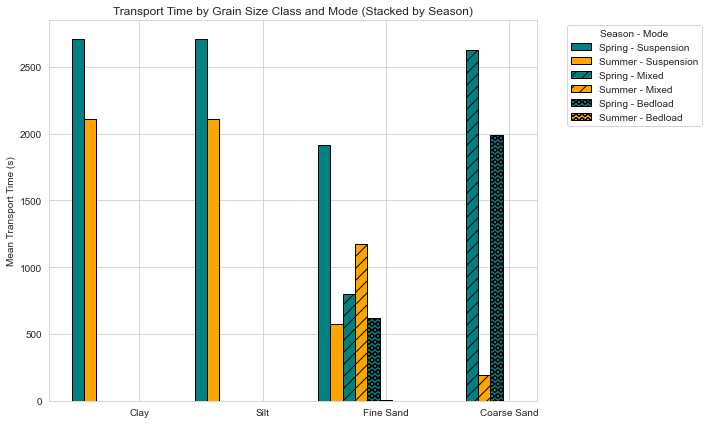

In [27]:
# store data in a dictionary for easier access
transport_times = {
    ('Spring', 'Suspension'): suspended_spring,
    ('Summer', 'Suspension'): suspended_summer,
    ('Spring', 'Mixed'): mixed_spring,
    ('Summer', 'Mixed'): mixed_summer,
    ('Spring', 'Bedload'): bedload_spring,
    ('Summer', 'Bedload'): bedload_summer,
}

# define plotting style
modes = ['Suspension', 'Mixed', 'Bedload']
seasons = ['Spring', 'Summer']
season_colors = {'Spring': 'teal', 'Summer': 'orange'}
hatches = {'Suspension': '', 'Mixed': '//', 'Bedload': 'OO'}
grain_classes = ['Clay', 'Silt', 'Fine Sand', 'Coarse Sand']

### PLOT ### 
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(grain_classes))  # base positions for grain classes
group_width = 0.6  # total width for all bars in one grain size class
bar_width = group_width / (len(modes) * len(seasons))  # bar width per mode-season

# plot each transport mode per grain size class 
for i, mode in enumerate(modes):
    for j, season in enumerate(seasons):
        times = transport_times[(season, mode)].reindex(grain_classes, fill_value=0).values

        # calculate offset: position inside the group
        offset = (i * len(seasons) + j - 5) * bar_width
        xpos = x + offset

        ax.bar(
            xpos,
            times,
            width=bar_width,
            color=season_colors[season],
            hatch=hatches[mode],
            edgecolor='black',
            label=f'{season} - {mode}'  # avoid legend duplicates
        )

ax.set_xticks(x)
ax.set_xticklabels(grain_classes)
ax.set_ylabel('Mean Transport Time (s)')
ax.set_title('Transport Time by Grain Size Class and Mode (Stacked by Season)')
ax.legend(title='Season - Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Grouped by season - with hatches

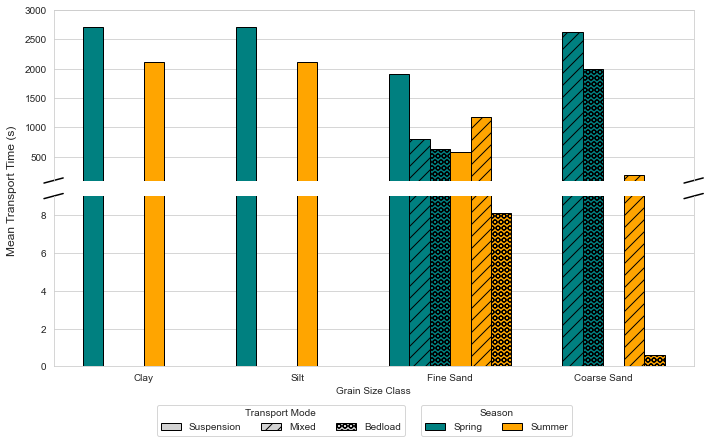

In [29]:
# store data in a dictionary for easier access
transport_times = {
    ('Spring', 'Suspension'): suspended_spring,
    ('Summer', 'Suspension'): suspended_summer,
    ('Spring', 'Mixed'): mixed_spring,
    ('Summer', 'Mixed'): mixed_summer,
    ('Spring', 'Bedload'): bedload_spring,
    ('Summer', 'Bedload'): bedload_summer,
}

# define plotting style
modes = ['Suspension', 'Mixed', 'Bedload']
seasons = ['Spring', 'Summer']
season_colors = {'Spring': 'teal', 'Summer': 'orange'}
hatches = {'Suspension': '', 'Mixed': '//', 'Bedload': 'OO'}
grain_classes = ['Clay', 'Silt', 'Fine Sand', 'Coarse Sand']

### PLOT ### 
# set up the plot with two subplots for the y-axis break
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 3]})
fig.subplots_adjust(hspace=0.05)

# axis break limits
break_min = 9
break_max = 90

# set y-axis limits for the broken parts
ax1.set_ylim(break_max, 3000)  # upper part of the y-axis
ax2.set_ylim(0, break_min)   # lower part of the y-axis

# hide spines and ticks to create the break effect
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.set_visible(False)

# add diagonal lines to indicate the break
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

x = np.arange(len(grain_classes))
num_subgroups = len(modes) * len(seasons)
group_width = 0.8
bar_width = group_width / num_subgroups

# list to track labels for the legend to avoid duplicates
legend_labels = []

for i, season in enumerate(seasons):
    for j, mode in enumerate(modes):
        times = transport_times[(season, mode)].reindex(grain_classes, fill_value=0).values
        # calculate the new offset based on season and mode index
        offset = (i * len(modes) + j) * bar_width - group_width / 2 + bar_width / 2
        xpos = x + offset
        label_text = f'{season} - {mode}'
        if label_text not in legend_labels:
            legend_labels.append(label_text)

        ax1.bar(
            xpos,
            times,
            width=bar_width,
            color=season_colors[season],
            hatch=hatches[mode],
            edgecolor='black',
            label=label_text
        )

        ax2.bar(
            xpos,
            times,
            width=bar_width,
            color=season_colors[season],
            hatch=hatches[mode],
            edgecolor='black'
        )

# set x-ticks and labels on the bottom subplot (ax2)
ax2.set_xticks(x)
ax2.set_xticklabels(grain_classes)
ax2.set_xlabel('Grain Size Class')
# set y axis
fig.supylabel('Mean Transport Time (s)')

# create legend elements for hatches (modes) and colors (seasons)
# hatch legend
hatch_legend_elements = [
    Patch(facecolor='lightgray', hatch=hatches[mode], edgecolor='black', label=mode) for mode in modes
]
fig.legend(handles=hatch_legend_elements, title='Transport Mode', loc='lower center', bbox_to_anchor=(0.4, -0.08), ncol=len(modes))

# season legend
season_legend_elements = [
    Patch(facecolor=season_colors[season], edgecolor='black', label=season) for season in seasons
]
fig.legend(handles=season_legend_elements, title='Season', loc='lower center', bbox_to_anchor=(0.7, -0.08), ncol=len(seasons))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('transport_time_barplot_hatches.png', dpi=1000)
plt.show()

Grouped by season - initials

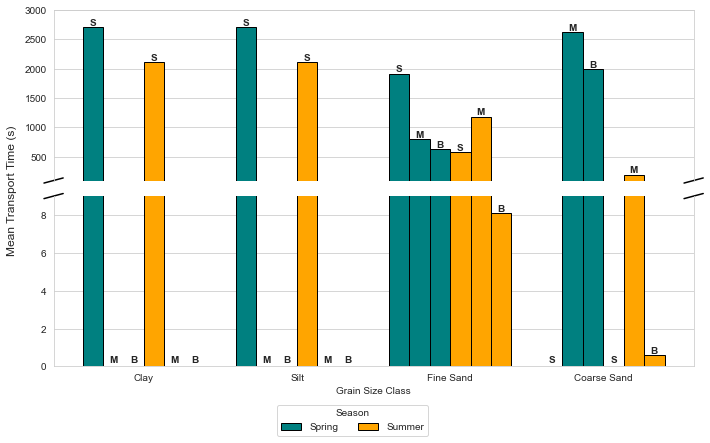

In [31]:
# store data in a dictionary for easier access
transport_times = {
    ('Spring', 'Suspension'): suspended_spring,
    ('Summer', 'Suspension'): suspended_summer,
    ('Spring', 'Mixed'): mixed_spring,
    ('Summer', 'Mixed'): mixed_summer,
    ('Spring', 'Bedload'): bedload_spring,
    ('Summer', 'Bedload'): bedload_summer,
}

# define plotting style
modes = ['Suspension', 'Mixed', 'Bedload']
seasons = ['Spring', 'Summer']
season_colors = {'Spring': 'teal', 'Summer': 'orange'}
hatches = {'Suspension': '', 'Mixed': '//', 'Bedload': 'OO'}
grain_classes = ['Clay', 'Silt', 'Fine Sand', 'Coarse Sand']

### PLOT ### 
# set up the plot with two subplots for the y-axis break
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 3]})
fig.subplots_adjust(hspace=0.05)

# axis break limits
break_min = 9
break_max = 90

# set y-axis limits for the broken parts
ax1.set_ylim(break_max, 3000)  # upper part of the y-axis
ax2.set_ylim(0, break_min)   # lower part of the y-axis

# hide spines and ticks to create the break effect
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.set_visible(False)

# add diagonal lines to indicate the break
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

x = np.arange(len(grain_classes))
num_subgroups = len(modes) * len(seasons)
group_width = 0.8
bar_width = group_width / num_subgroups

# list to track labels for the legend to avoid duplicates
mode_initials = {'Suspension': 'S', 'Mixed': 'M', 'Bedload': 'B'}

for i, season in enumerate(seasons):
    for j, mode in enumerate(modes):
        times = transport_times[(season, mode)].reindex(grain_classes).fillna(0).values
        offset = (i * len(modes) + j) * bar_width - group_width / 2 + bar_width / 2
        xpos = x + offset

        ax1.bar(
            xpos,
            times,
            width=bar_width,
            color=season_colors[season],
            edgecolor='black',
        )

        ax2.bar(
            xpos,
            times,
            width=bar_width,
            color=season_colors[season],
            edgecolor='black'
        )
        # add text labels on top of the bars
        for k, time in enumerate(times):
            text_x = xpos[k]
            text_y = time
            
            # if time is zero, set a small offset for the text
            if time == 0:
                text_y = 0.1
            
            if time >= break_max:
                ax1.text(
                    text_x,
                    text_y,
                    mode_initials[mode],
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    fontweight='bold'
                )
            else:
                ax2.text(
                    text_x,
                    text_y,
                    mode_initials[mode],
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    fontweight='bold'
                )

# set x-ticks and labels on the bottom subplot (ax2)
ax2.set_xticks(x)
ax2.set_xticklabels(grain_classes)
ax2.set_xlabel('Grain Size Class')
# set y axis
fig.supylabel('Mean Transport Time (s)')

# season legend
season_legend_elements = [
    Patch(facecolor=season_colors[season], edgecolor='black', label=season) for season in seasons
]
fig.legend(handles=season_legend_elements, title='Season', loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=len(seasons))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('transport_time_barplot_initials.png', dpi=1000)
plt.show()

Grouped by season - with hatches and initials

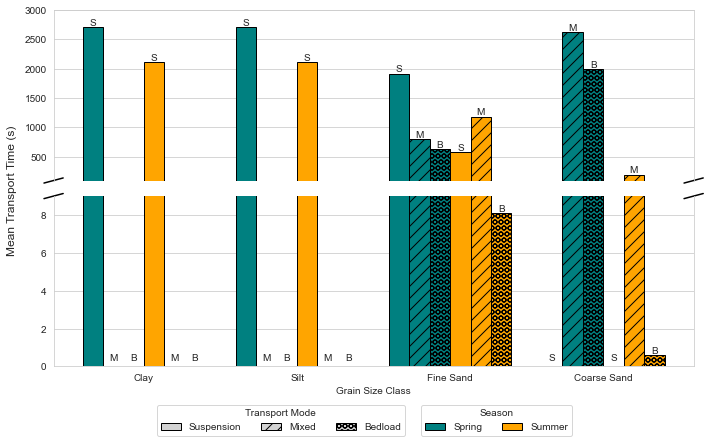

In [32]:
# store data in a dictionary for easier access
transport_times = {
    ('Spring', 'Suspension'): suspended_spring,
    ('Summer', 'Suspension'): suspended_summer,
    ('Spring', 'Mixed'): mixed_spring,
    ('Summer', 'Mixed'): mixed_summer,
    ('Spring', 'Bedload'): bedload_spring,
    ('Summer', 'Bedload'): bedload_summer,
}

# define plotting style
modes = ['Suspension', 'Mixed', 'Bedload']
seasons = ['Spring', 'Summer']
season_colors = {'Spring': 'teal', 'Summer': 'orange'}
hatches = {'Suspension': '', 'Mixed': '//', 'Bedload': 'OO'}
grain_classes = ['Clay', 'Silt', 'Fine Sand', 'Coarse Sand']

### PLOT ### 
# set up the plot with two subplots for the y-axis break
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 3]})
fig.subplots_adjust(hspace=0.05)

# axis break limits
break_min = 9
break_max = 90

# set y-axis limits for the broken parts
ax1.set_ylim(break_max, 3000)  # upper part of the y-axis
ax2.set_ylim(0, break_min)   # lower part of the y-axis

# hide spines and ticks to create the break effect
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.set_visible(False)

# add diagonal lines to indicate the break
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

x = np.arange(len(grain_classes))
num_subgroups = len(modes) * len(seasons)
group_width = 0.8
bar_width = group_width / num_subgroups

# list to track labels for the legend to avoid duplicates
legend_labels = []

for i, season in enumerate(seasons):
    for j, mode in enumerate(modes):
        times = transport_times[(season, mode)].reindex(grain_classes).fillna(0).values
        # calculate the new offset based on season and mode index
        offset = (i * len(modes) + j) * bar_width - group_width / 2 + bar_width / 2
        xpos = x + offset
        label_text = f'{season} - {mode}'
        if label_text not in legend_labels:
            legend_labels.append(label_text)

        ax1.bar(
            xpos,
            times,
            width=bar_width,
            color=season_colors[season],
            hatch=hatches[mode],
            edgecolor='black',
            label=label_text
        )

        ax2.bar(
            xpos,
            times,
            width=bar_width,
            color=season_colors[season],
            hatch=hatches[mode],
            edgecolor='black'
        )

        # add text labels on top of the bars
        for k, time in enumerate(times):
            text_x = xpos[k]
            text_y = time
            
            # if time is zero, set a small offset for the text
            if time == 0:
                text_y = 0.2
            
            if time >= break_max:
                ax1.text(
                    text_x,
                    text_y,
                    mode_initials[mode],
                    ha='center',
                    va='bottom',
                    fontsize=10
                )
            else:
                ax2.text(
                    text_x,
                    text_y,
                    mode_initials[mode],
                    ha='center',
                    va='bottom',
                    fontsize=10
                )


# set x-ticks and labels on the bottom subplot (ax2)
ax2.set_xticks(x)
ax2.set_xticklabels(grain_classes)
ax2.set_xlabel('Grain Size Class')
# set y axis
fig.supylabel('Mean Transport Time (s)')

# create legend elements for hatches (modes) and colors (seasons)
# hatch legend
hatch_legend_elements = [
    Patch(facecolor='lightgray', hatch=hatches[mode], edgecolor='black', label=mode) for mode in modes
]
fig.legend(handles=hatch_legend_elements, title='Transport Mode', loc='lower center', bbox_to_anchor=(0.4, -0.08), ncol=len(modes))

# season legend
season_legend_elements = [
    Patch(facecolor=season_colors[season], edgecolor='black', label=season) for season in seasons
]
fig.legend(handles=season_legend_elements, title='Season', loc='lower center', bbox_to_anchor=(0.7, -0.08), ncol=len(seasons))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('transport_time_barplot_both.png', dpi=1000)
plt.show()

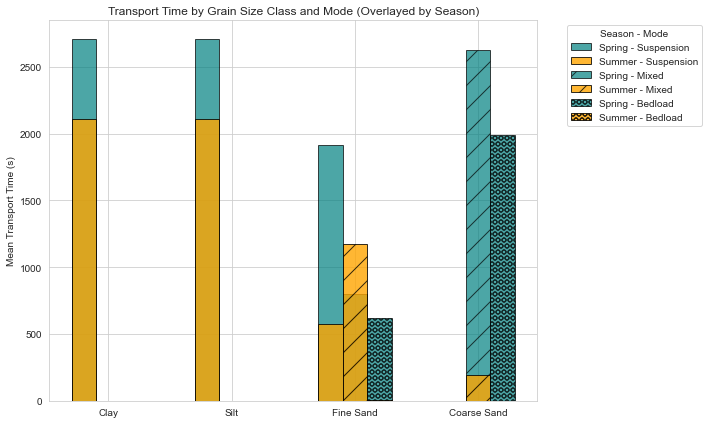

In [33]:
# store data in a dictionary for easier access
transport_times = {
    ('Spring', 'Suspension'): suspended_spring,
    ('Summer', 'Suspension'): suspended_summer,
    ('Spring', 'Mixed'): mixed_spring,
    ('Summer', 'Mixed'): mixed_summer,
    ('Spring', 'Bedload'): bedload_spring,
    ('Summer', 'Bedload'): bedload_summer,
}

# define plotting style
modes = ['Suspension', 'Mixed', 'Bedload']
seasons = ['Spring', 'Summer']
season_colors = {'Spring': 'teal', 'Summer': 'orange'}
hatches = {'Suspension': '', 'Mixed': '/', 'Bedload': 'OO'}
grain_classes = ['Clay', 'Silt', 'Fine Sand', 'Coarse Sand']

# setup the plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(grain_classes))  # grain class positions
bar_width = 0.2

# mode offsets so we have 3 bars per grain class (Suspension, Mixed, Bedload)
mode_offsets = {
    'Suspension': -bar_width,
    'Mixed': 0,
    'Bedload': bar_width
}

for mode in modes:
    offset = mode_offsets[mode]

    spring_vals = transport_times[('Spring', mode)].reindex(grain_classes, fill_value=0).values
    summer_vals = transport_times[('Summer', mode)].reindex(grain_classes, fill_value=0).values
    xpos = x + offset


    # plot Spring (taller, background)
    ax.bar(
        xpos,
        spring_vals,
        width=bar_width,
        color=season_colors['Spring'],
        hatch=hatches[mode],
        edgecolor='black',
        alpha=0.7,
        label=f'Spring - {mode}' # avoid dupes in legend
    )
    # plot Summer (foreground, partially transparent)
    ax.bar(
        xpos,
        summer_vals,
        width=bar_width,
        color=season_colors['Summer'],
        hatch=hatches[mode],
        edgecolor='black',
        alpha=0.8,
        label=f'Summer - {mode}' 
    )

# formatting
ax.set_xticks(x)
ax.set_xticklabels(grain_classes)
ax.set_ylabel('Mean Transport Time (s)')
ax.set_title('Transport Time by Grain Size Class and Mode (Overlayed by Season)')
ax.legend(title='Season - Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Bar plots by mode of transport

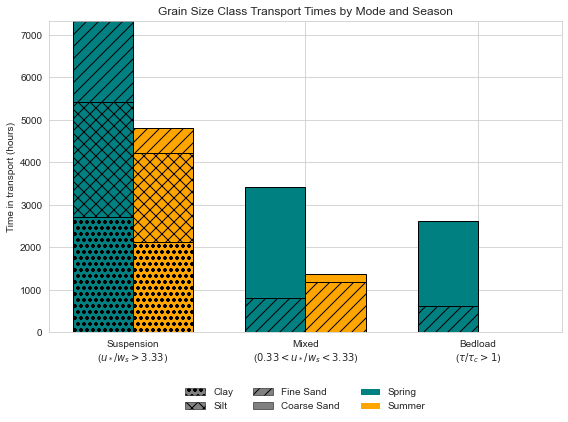

In [34]:
# define grain classes and hatches
modes = ['Suspension', 'Mixed', 'Bedload']
seasons = ['Spring', 'Summer']
season_colors = {'Spring': 'teal', 'Summer': 'orange'}
grain_classes = ['Clay', 'Silt', 'Fine Sand', 'Coarse Sand']
hatch_styles = ['oo', 'xx', '//', '']  # one per grain class

# Set up plot
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35
x = np.arange(len(modes))  # position for each transport mode

# Loop through seasons and grain sizes to stack bars
for i, season in enumerate(seasons):
    for j, mode in enumerate(modes):
        series = transport_times.get((season, mode), {})
        bottom = 0
        for k, grain in enumerate(grain_classes):
            value = series.get(grain, 0)
            if np.isnan(value):
                value = 0
            ax.bar(
                x[j] + (i - 0.5) * bar_width,
                value,
                width=bar_width,
                bottom=bottom,
                color=season_colors[season],
                label=f"{season}" if k == 0 else "",  # avoid duplicate legend
                hatch=hatch_styles[k],
                edgecolor='black'
            )
            bottom += value

# Customizing the plot
ax.set_xticks(x)
ax.set_xticklabels(ax.set_xticklabels([
    "Suspension\n($u_*/w_s > 3.33$)",
    "Mixed\n($0.33 < u_*/w_s < 3.33$)",
    "Bedload\n($\\tau/\\tau_c > 1$)"
]))
ax.set_ylabel("Time in transport (hours)")
ax.set_title("Grain Size Class Transport Times by Mode and Season")

# create legend for grain sizes (hatch styles)
grain_hatches = {'Coarse Sand': '', 'Fine Sand': '//', 'Silt': 'xx', 'Clay': 'oo'}
grain_patches = [
    Patch(facecolor='gray', hatch=grain_hatches[grain], label=grain, edgecolor='black', linewidth=0.5)
    for grain in grain_classes]
# create legend for seasons (colors)
season_patches = [
    Patch(facecolor=season_colors[season], label=season)
    for season in seasons]
# combine both legends into one and place at the bottom
all_patches = grain_patches + season_patches
# add combined legend at the bottom
plt.legend(
    handles=all_patches,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # adjust spacing here if needed
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()

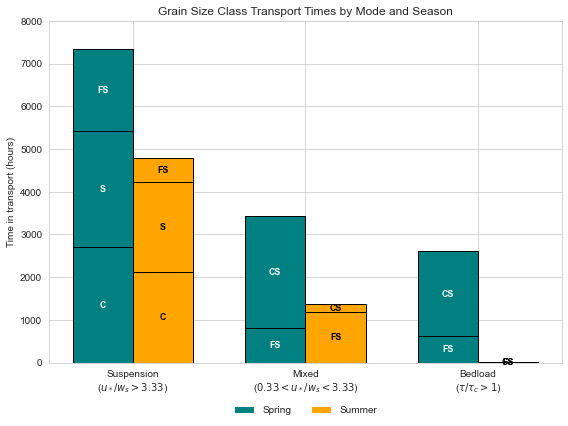

In [35]:
# define grain classes and hatches
modes = ['Suspension', 'Mixed', 'Bedload']
seasons = ['Spring', 'Summer']
season_colors = {'Spring': 'teal', 'Summer': 'orange'}
grain_classes = ['Clay', 'Silt', 'Fine Sand', 'Coarse Sand']
grain_initials = {'Clay': 'C', 'Silt': 'S', 'Fine Sand': 'FS', 'Coarse Sand': 'CS'}

# Set up plot
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35
x = np.arange(len(modes))  # position for each transport mode

# Loop through seasons and grain sizes to stack bars
for i, season in enumerate(seasons):
    for j, mode in enumerate(modes):
        series = transport_times.get((season, mode), {})
        bottom = 0
        for k, grain in enumerate(grain_classes):
            value = series.get(grain, 0)
            if np.isnan(value):
                value = 0
            # draw the bar
            bar = ax.bar(
                x[j] + (i - 0.5) * bar_width,
                value,
                width=bar_width,
                bottom=bottom,
                color=season_colors[season],
                label=f"{season}" if k == 0 else "",  # avoid duplicate legend
                edgecolor='black'
            )
            # add the grain size initial text
            if value > 0:
                ax.text(
                    x[j] + (i - 0.5) * bar_width,
                    bottom + value / 2,
                    grain_initials[grain],
                    ha='center',
                    va='center',
                    fontsize=9,
                    color='white' if season == 'Spring' else 'black',  # contrast text
                    weight='bold'
                )
            bottom += value

# customization
ax.set_xticks(x)
ax.set_ylim(0, 8000)  
ax.set_xticklabels(ax.set_xticklabels([
    "Suspension\n($u_*/w_s > 3.33$)",
    "Mixed\n($0.33 < u_*/w_s < 3.33$)",
    "Bedload\n($\\tau/\\tau_c > 1$)"
]))
ax.set_ylabel("Time in transport (hours)")
ax.set_title("Grain Size Class Transport Times by Mode and Season")

# create legend for seasons (colors)
season_patches = [
    Patch(facecolor=season_colors[season], label=season)
    for season in seasons]
# add combined legend at the bottom
plt.legend(
    handles=season_patches,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),  # adjust spacing here if needed
    ncol=2,
    frameon=False
)

plt.tight_layout()
plt.show()

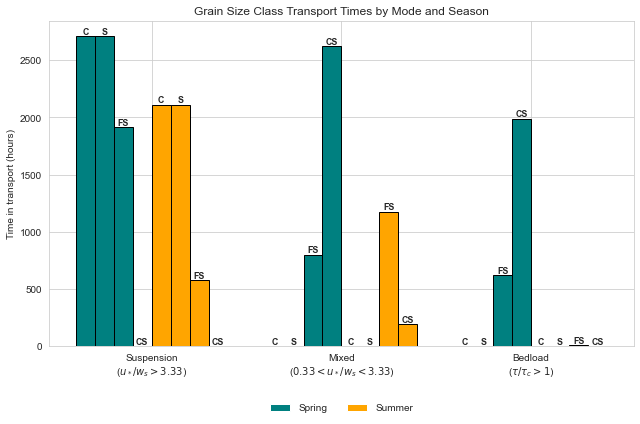

In [36]:
# define grain classes and hatches
modes = ['Suspension', 'Mixed', 'Bedload']
seasons = ['Spring', 'Summer']
season_colors = {'Spring': 'teal', 'Summer': 'orange'}
grain_classes = ['Clay', 'Silt', 'Fine Sand', 'Coarse Sand']
grain_initials = {'Clay': 'C', 'Silt': 'S', 'Fine Sand': 'FS', 'Coarse Sand': 'CS'}

fig, ax = plt.subplots(figsize=(9, 6))
n_modes = len(modes)
n_grains = len(grain_classes)
bar_width = 0.1  # narrower bars to fit all 8 per group
group_width = 8 * bar_width  # width of each group (8 bars)

# loop through all combinations
for i, mode in enumerate(modes):
    group_center = i  # center of the group on x-axis
    for j, season in enumerate(seasons):
        for k, grain in enumerate(grain_classes):
            value = transport_times.get((season, mode), {}).get(grain, 0)
            if np.isnan(value):
                value = 0

            # calculate bar position
            bar_index = j * n_grains + k  # 0–7
            bar_x = group_center - group_width / 2 + bar_index * bar_width + bar_width / 2

            # draw bar
            ax.bar(
                bar_x,
                value,
                width=bar_width,
                color=season_colors[season],
                edgecolor='black'
            )

            # add grain initial
            label_y = value + 0.05 if value > 0 else 0.38
            ax.text(
                bar_x,
                label_y,  # adjust height for label placement
                grain_initials[grain],
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold'
            )

# set custom x-axis ticks at group centers
ax.set_xticks(np.arange(n_modes))
ax.set_xticklabels([
    "Suspension\n($u_*/w_s > 3.33$)",
    "Mixed\n($0.33 < u_*/w_s < 3.33$)",
    "Bedload\n($\\tau/\\tau_c > 1$)"
])
#ax.set_yscale('log')
ax.set_ylabel("Time in transport (hours)")
ax.set_title("Grain Size Class Transport Times by Mode and Season")

# create legend for seasons
season_patches = [
    Patch(facecolor=season_colors[season], label=season)
    for season in seasons
]
plt.legend(
    handles=season_patches,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False
)

plt.tight_layout()
plt.show()

Separating by Y axis scale

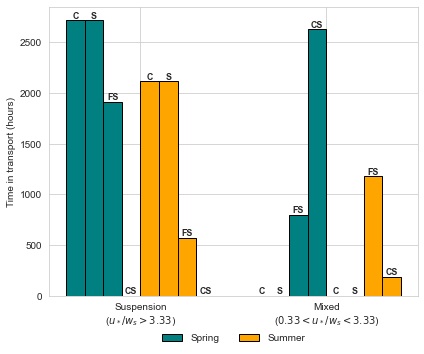

In [37]:
# define grain classes and hatches
modes = ['Suspension', 'Mixed']
seasons = ['Spring', 'Summer']
season_colors = {'Spring': 'teal', 'Summer': 'orange'}
grain_classes = ['Clay', 'Silt', 'Fine Sand', 'Coarse Sand']
grain_initials = {'Clay': 'C', 'Silt': 'S', 'Fine Sand': 'FS', 'Coarse Sand': 'CS'}

fig, ax = plt.subplots(figsize=(6, 5))
n_modes = len(modes)
n_grains = len(grain_classes)
bar_width = 0.1  # narrower bars to fit all 8 per group
group_width = 8 * bar_width  # width of each group (8 bars)

# loop through all combinations
for i, mode in enumerate(modes):
    group_center = i  # center of the group on x-axis
    for j, season in enumerate(seasons):
        for k, grain in enumerate(grain_classes):
            value = transport_times.get((season, mode), {}).get(grain, 0)
            if np.isnan(value):
                value = 0

            # calculate bar position
            bar_index = j * n_grains + k  # 0–7
            bar_x = group_center - group_width / 2 + bar_index * bar_width + bar_width / 2

            # draw bar
            ax.bar(
                bar_x,
                value,
                width=bar_width,
                color=season_colors[season],
                edgecolor='black'
            )

            # add grain initial
            label_y = value + 0.05 if value > 0 else 4.6
            ax.text(
                bar_x,
                label_y,  # adjust height for label placement
                grain_initials[grain],
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold'
            )

# set custom x-axis ticks at group centers
ax.set_xticks(np.arange(n_modes))
ax.set_xticklabels([
    "Suspension\n($u_*/w_s > 3.33$)",
    "Mixed\n($0.33 < u_*/w_s < 3.33$)",
])
#ax.set_yscale('log')
ax.set_ylabel("Time in transport (hours)")

# create legend for seasons
season_patches = [
    Patch(facecolor=season_colors[season], label=season, edgecolor='black')
    for season in seasons
]
plt.legend(
    handles=season_patches,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    frameon=False
)

plt.tight_layout()
plt.show()

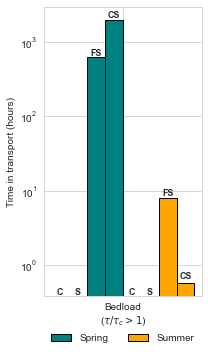

In [38]:
# define grain classes and hatches
modes = ['Bedload']
seasons = ['Spring', 'Summer']
season_colors = {'Spring': 'teal', 'Summer': 'orange'}
grain_classes = ['Clay', 'Silt', 'Fine Sand', 'Coarse Sand']
grain_initials = {'Clay': 'C', 'Silt': 'S', 'Fine Sand': 'FS', 'Coarse Sand': 'CS'}

fig, ax = plt.subplots(figsize=(3, 5))
n_modes = len(modes)
n_grains = len(grain_classes)
bar_width = 0.0001  # narrower bars to fit all 8 per group
group_width = 8 * bar_width  # width of each group (8 bars)

# loop through all combinations
for i, mode in enumerate(modes):
    group_center = i  # center of the group on x-axis
    for j, season in enumerate(seasons):
        for k, grain in enumerate(grain_classes):
            value = transport_times.get((season, mode), {}).get(grain, 0)
            if np.isnan(value):
                value = 0

            # calculate bar position
            bar_index = j * n_grains + k  # 0–7
            bar_x = group_center - group_width / 2 + bar_index * bar_width + bar_width / 2

            # draw bar
            ax.bar(
                bar_x,
                value,
                width=bar_width,
                color=season_colors[season],
                edgecolor='black'
            )

            # add grain initial
            label_y = value + 0.05 if value > 0 else 0.38
            ax.text(
                bar_x,
                label_y,  # adjust height for label placement
                grain_initials[grain],
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold'
            )

# set custom x-axis ticks at group centers
ax.set_xticks(np.arange(n_modes))
ax.set_xticklabels([
    "Bedload\n($\\tau/\\tau_c > 1$)",
])
ax.set_yscale('log')
ax.set_ylabel("Time in transport (hours)")

# create legend for seasons
season_patches = [
    Patch(facecolor=season_colors[season], label=season, edgecolor='black')
    for season in seasons
]
plt.legend(
    handles=season_patches,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    frameon=False
)

plt.tight_layout()
plt.show()

### All together as lines

In [39]:
transport_lines = {'Suspended': '-', 'Mixed': '--', 'Bedload': ':'}
print(transport_lines['Suspended'])

-


In [40]:
# function to plot each season/class combination
def plot_season(ax, df, season_label, color, transport_mode):
        ax.plot(
            df['size'],
            df['time'],
            color=color,
            linestyle=transport_lines[transport_mode],
            linewidth=3,
            alpha=1,
            label=f"{season_label} - {transport_mode}",
            zorder=2
        )
        ax.scatter(
            df['size'],
            df['time'],
            color=color,
            marker='o',
            s=60,
            label=None,
            edgecolor='black',
            alpha=0.8, 
            zorder=3
        )

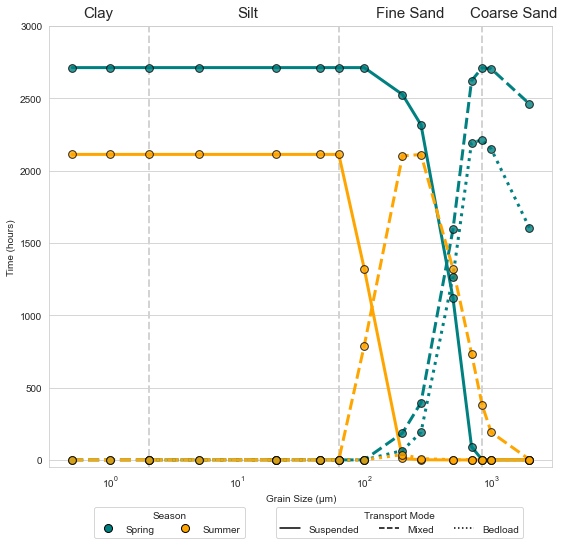

In [41]:
# color and marker mapping
season_colors = {'Spring': 'teal', 'Summer': 'orange'}
transport_lines = {'Suspended': '-', 'Mixed': '--', 'Bedload': ':'}

fig, ax = plt.subplots(figsize=(8, 8))
sns.set_style('whitegrid')

# plot verticlar grain size boundaries
for boundary in [2, 63, 850]:
    ax.axvline(x=boundary, color='lightgray', linestyle='--', linewidth=2, zorder=1)

# suspension load lines
plot_season(ax, suspended_spring_times, 'Spring', season_colors['Spring'], 'Suspended')
plot_season(ax, suspended_summer_times, 'Summer', season_colors['Summer'], 'Suspended')
# mixed load lines
plot_season(ax, mixed_spring_times, 'Spring', season_colors['Spring'], 'Mixed')
plot_season(ax, mixed_summer_times, 'Summer', season_colors['Summer'], 'Mixed')
# bedload load lines
plot_season(ax, bedload_spring_times, 'Spring', season_colors['Spring'], 'Bedload')
plot_season(ax, bedload_summer_times, 'Summer', season_colors['Summer'], 'Bedload')

# axis formatting
ax.set_xlabel('Grain Size (µm)')
ax.set_ylabel('Time (hours)')
ax.set_ylim(-50, 3000)  # set y-axis limits for better visibility
ax.set_xscale('log')
#ax.set_yscale('log')
ax.xaxis.grid(False)

# legends
season_legend = [
    Line2D([0], [0], marker='o', color='w', label=season,
            markerfacecolor=color, markeredgecolor='black', markersize=8)
    for season, color in season_colors.items()
]

transport_legend = [
    Line2D([0], [0], color='black', linestyle=style, linewidth=1.5, label=mode)
    for mode, style in transport_lines.items()
]

# add legends
fig.legend(handles=season_legend, title='Season', loc='lower center', bbox_to_anchor=(0.3, 0.05), ncol=2)
fig.legend(handles=transport_legend, title='Transport Mode', loc='lower center', bbox_to_anchor=(0.7, 0.05), ncol=3)

# Add grain size class labels at the top of the plot
y_pos = ax.get_ylim()[1] * 1.02  # a bit above the top of the y-axis
ax.text(0.8, y_pos, 'Clay', ha='center', fontsize=15)
ax.text(12, y_pos, 'Silt', ha='center', fontsize=15)
ax.text(230, y_pos, 'Fine Sand', ha='center', fontsize=15)
ax.text(1500, y_pos, 'Coarse Sand', ha='center', fontsize=15)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # make room for legends
plt.show()

Seasonal Subplot

C:\Users\huck4481\AppData\Local\Temp\ipykernel_4340\675127747.py:61: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(-10, 5000)


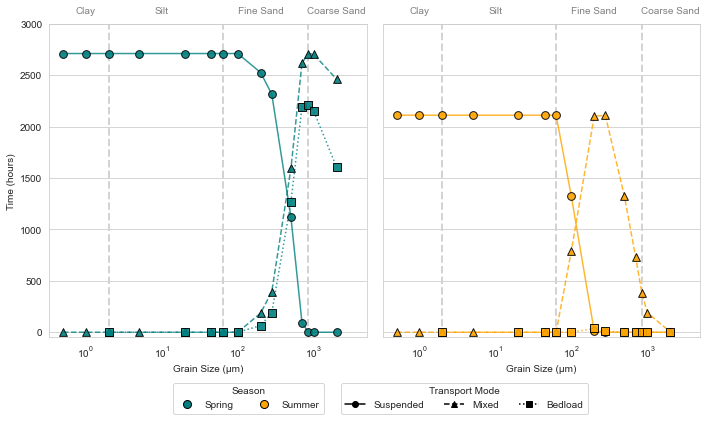

In [42]:
# color and marker mapping
season_colors = {'Spring': 'teal', 'Summer': 'orange'}
transport_lines = {'Suspended': '-', 'Mixed': '--', 'Bedload': ':'}
transport_markers = {'Suspended': 'o', 'Mixed': '^', 'Bedload': 's'} 

fig, axes = plt.subplots(ncols=2, figsize=(10, 6), sharey=True)
sns.set_style('whitegrid')

# grain size boundaries
boundaries = [2, 63, 850]
grain_labels = {'Clay': 1, 'Silt': 10, 'Fine Sand': 200, 'Coarse Sand': 2000}

# data summarizing per season
season_data = {
    'Spring': {
        'Suspended': suspended_spring_times,
        'Mixed': mixed_spring_times,
        'Bedload': bedload_spring_times
    },
    'Summer': {
        'Suspended': suspended_summer_times,
        'Mixed': mixed_summer_times,
        'Bedload': bedload_summer_times
    }
}

# plot for each season
for i, (season, ax) in enumerate(zip(season_data.keys(), axes)):
    color = season_colors[season]
    
    # plot vertical grain size boundaries
    for boundary in boundaries:
        ax.axvline(x=boundary, color='lightgray', linestyle='--', linewidth=2, zorder=1)
    
    # plot each transport mode
    for mode, df in season_data[season].items():
        ax.plot(
            df['size'],
            df['time'],
            color=color,
            linestyle=transport_lines[mode],
            linewidth=1.5,
            alpha=0.8,
            label=f"{season} - {mode}"
        )
        ax.scatter(
            df['size'],
            df['time'],
            color=color,
            marker=transport_markers[mode],
            s=60,
            label=None,
            edgecolor='black',
            alpha=0.9, 
            zorder=3
        )
    
    # axes formatting
    #ax.set_title(f"{season}")
    ax.set_xscale('log')
    ax.set_xlim(-10, 5000)
    ax.set_ylim(-50, 3000)
    ax.xaxis.grid(False)

    if i == 0:
        ax.set_ylabel('Time (hours)')
    ax.set_xlabel('Grain Size (µm)')
    
    # add grain size class labels
    y_pos = 3100
    for label, xpos in grain_labels.items():
        ax.text(xpos, y_pos, label, ha='center', fontsize=10, color='gray')

# legends
season_legend = [
    Line2D([0], [0], marker='o', color='w', label=season,
            markerfacecolor=color, markeredgecolor='black', markersize=8)
    for season, color in season_colors.items()
]

transport_legend = [
    Line2D([0], [0], color='black', linestyle=transport_lines[mode], marker=transport_markers[mode], linewidth=1.5, label=mode)
    for mode, style in transport_lines.items()
]

# add legends
fig.legend(handles=season_legend, title='Season', loc='lower center', bbox_to_anchor=(0.35, 0.02), ncol=2)
fig.legend(handles=transport_legend, title='Transport Mode', loc='lower center', bbox_to_anchor=(0.65, 0.02), ncol=3)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # make room for legends
plt.show()